In [1]:
import time
import json  # for checkpointing
import csv

from collections import Counter

from pathlib import Path

import numpy as np
import scipy.sparse
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from tqdm.notebook import trange, tqdm

import pandas as pd

import datetime

import os
from dotenv import load_dotenv, find_dotenv

from timeit import default_timer as timer

load_dotenv(find_dotenv('config.env'))

torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)
torch.cuda.is_available()

import sklearn
import sklearn.metrics
import seaborn as sns


# PLOT PAGES
### https://seaborn.pydata.org/examples/index.html
### https://seaborn.pydata.org/generated/seaborn.diverging_palette.html
### https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f

In [160]:
diverging_palette_dark = sns.diverging_palette(250, 15, s=75, l=40, n=2, center="dark")
diverging_palette_light = sns.diverging_palette(240, 10, n=2, center="light")
diverging_palette_heatmap = sns.color_palette("icefire", as_cmap=True)

display(diverging_palette_dark)
display(diverging_palette_light)
display(diverging_palette_heatmap)

[(0.20651240887022015, 0.3755393698154809, 0.5856904756194529),
 (0.6565296443848212, 0.21867290090002556, 0.1744737357010414)]

[(0.2564697186166857, 0.4871591358142198, 0.657003695890986),
 (0.8545371341681446, 0.22957019267094914, 0.2762321841840895)]

In [2]:
# PLOT PAGES
# 

# for p in sns.palettes.SEABORN_PALETTES:
#     print(p)
#     sns.set_palette(p)
#     sns.palplot(sns.color_palette())
#     plt.show()

In [3]:
# sns.set_style("ticks")
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_style("whitegrid")
# sns.set_style("darkgrid")

sns.set_palette('bright')

In [4]:
!nvidia-smi

Sun Apr 18 17:42:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:B9:00.0 Off |                    0 |
| N/A   29C    P0    48W / 350W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
ticks_tiles_newlined = [
    "1\nman",
    "2\nman",
    "3\nman",
    "4\nman",
    "5\nman",
    "6\nman",
    "7\nman",
    "8\nman",
    "9\nman",
    "1\npin",
    "2\npin",
    "3\npin",
    "4\npin",
    "5\npin",
    "6\npin",
    "7\npin",
    "8\npin",
    "9\npin",
    "1\nsou",
    "2\nsou",
    "3\nsou",
    "4\nsou",
    "5\nsou",
    "6\nsou",
    "7\nsou",
    "8\nsou",
    "9\nsou",
    "\nEast",
    "\nSouth",
    "\nWest",
    "\nNorth",
    "\nHaku",
    "\nHatsu",
    "\nChun"
]

ticks_tiles_oneline = [
    "1 man",
    "2 man",
    "3 man",
    "4 man",
    "5 man",
    "6 man",
    "7 man",
    "8 man",
    "9 man",
    "1 pin",
    "2 pin",
    "3 pin",
    "4 pin",
    "5 pin",
    "6 pin",
    "7 pin",
    "8 pin",
    "9 pin",
    "1 sou",
    "2 sou",
    "3 sou",
    "4 sou",
    "5 sou",
    "6 sou",
    "7 sou",
    "8 sou",
    "9 sou",
    "East",
    "South",
    "West",
    "North",
    "Haku",
    "Hatsu",
    "Chun"
]

In [8]:
##############################################
# PARAMETERS
##############################################
torch.manual_seed(0)
np.random.seed(0)

DEVICE = torch.device("cuda")
EPOCHS = 20
DATASET_CONFIG = 'balanced_test_medium'
SHUFFLE_DATASET = True

if DEVICE.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0) / 1024 ** 3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0) / 1024 ** 3, 1), 'GB')

Tesla V100-SXM3-32GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [9]:
class DiscardDataset(torch.utils.data.Dataset):

    def __init__(self, data_path, years: list, n_rows: int = None, phase: int = None, balance_data: bool = False):
        """ If n_rows = None -> get all """ 
        
        # Invalid Parameter Combinations
        if balance_data:
            if not n_rows:
                raise BaseException("`n_rows` must be defined if `balance_data` is True!")
            elif n_rows < 34:
                raise BaseException("Cannot balance data if `n_rows` < 34!")
        
        ALL_YEARS = (2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019)
        invalid_years = set(years) - set(ALL_YEARS)
        if invalid_years:
            raise Exception(f"INVALID YEARS: {invalid_years}")
        
        # Dataset Print
        if n_rows:
            print(f"Loading Dataset with {n_rows:>13,} rows", end=' ')
        else:
            print(f"Loading Dataset with all rows", end=' ')

        if phase in [0, 1, 2]:
            print(f"(Phase {phase})", end=' ')
        else:
            print(f"(All Phases)", end=' ')
            
        print("{:<14}".format("<BALANCED>" if balance_data else '<NOT BALANCED>'), end=' ')
        
        print(years)
            
        temp_matrices = []
        finished = False
        
        # Used when balance_data = False and n_rows != None
        loaded_rows = 0  
        
        # Used when balance_data = True
        class_bins = np.zeros(34)
        baseline_bin_size = n_rows // 34  # The expected size of the smallest bin

        if balance_data:
            paths_load_bar = tqdm(total=baseline_bin_size * 34, unit='rows', position=0)
        else:
            paths_load_bar = tqdm(total=n_rows, unit='rows', position=0)

        for year in years:

            paths = (Path(data_path) / str(year)).iterdir()

            for idx, path in enumerate(paths):

                arr = scipy.sparse.load_npz(path).toarray()

                if phase in [0, 1, 2]:
                    phased_matrices = self.generate_phase_column(arr)
                    arr = phased_matrices[phase]

                temp_matrices.append(arr)

                paths_load_bar.set_postfix(year=year, files_loaded=(idx + 1))  # Update Bar

                if balance_data:
                    
                    class_bins += np.bincount(arr[:, -1], minlength=34)
                    smallest_class_bin = int(np.amin(class_bins))

                    paths_load_bar.n = smallest_class_bin * 34
                    paths_load_bar.refresh()
                    
                    if baseline_bin_size <= smallest_class_bin:
                        finished = True
                        break

                else:
                    paths_load_bar.update(arr.shape[0])
                    
                    if n_rows:
                        loaded_rows += arr.shape[0]
                        if n_rows <= loaded_rows:
                            finished = True
                            break

            if finished:  # Early Stopping
                break
                
        if not finished and nrows:
            raise BaseException("`n_rows` is higher than found rows -- Either lower `n_rows` or include more annual datasets!")
            
        if balance_data:
            matrix = np.concatenate(temp_matrices, axis=0)
            matrix = matrix[np.argsort(matrix[:, -1])]  # Sort rows by last column (the y-value)
            sorted_rows = np.array_split(matrix, np.where(np.diff(matrix[:, -1])!=0)[0]+1)  # Organize rows according to their last column's value into a list
            for i in range(len(sorted_rows)):
                sorted_rows[i] = sorted_rows[i][:baseline_bin_size]  # The balancing action

            final_arr = np.concatenate(sorted_rows, axis=0)
        else:
            final_arr = np.vstack(temp_matrices)

            if n_rows:
                final_arr = final_arr[:n_rows]

        # Finalize tqdm bar
        paths_load_bar.n = final_arr.shape[0]
        paths_load_bar.last_print_n = final_arr.shape[0]
        paths_load_bar.refresh()
        paths_load_bar.close()

        self.x_data = torch.FloatTensor(final_arr[:, :-1])  # Must be Float it seems
        self.y_data = torch.LongTensor(final_arr[:, -1])  # Must be Long it seems

    @staticmethod
    def generate_phase_column(array: np.array) -> np.array:
        # Begin with merging all pools together

        merged_discards = array[:, 238:]  # Discards
        merged_discards = np.sum(merged_discards, axis=1)

        phases = np.zeros([array.shape[0]])  # Early Game
        phases[(24 < merged_discards) & (merged_discards <= 48)] = 1  # Mid Game
        phases[(48 < merged_discards)] = 2  # End Game

        return array[(phases == 0)], array[(phases == 1)], array[(phases == 2)]

    def __len__(self):
        return self.x_data.shape[0]

    def __getitem__(self, idx):
        return {
            'X': self.x_data[idx],
            'y': self.y_data[idx]
        }

# DATASET

In [10]:
# Load from configurations
ds_configs = pd.read_csv('Dataset Configurations.csv', index_col='dataset_name')
selected_config = ds_configs.loc[DATASET_CONFIG]
selected_config

train_size          340000
validation_size       1000
test_size             1000
batch                   32
phases                  -1
years_training        1100
years_validation        10
years_testing            1
balanced_data          110
Name: balanced_test_medium, dtype: int64

In [11]:
def get_years(code: str) -> list:
    code = int(f"0b{code:0>11}", 2)
    found_years = []
    for i in range(11):
        if (code >> i) & 1:
            found_years.append(2019 - i)
    found_years.reverse()
    return found_years

In [12]:
def get_balanced_data_options(code: str):
    results = [False, False, False]
    code = int(f"0b{code:0>11}", 2)
    results[0] = code & 0b100 != 0
    results[1] = code & 0b010 != 0
    results[2] = code & 0b001 != 0
    return results

In [13]:
print("\nLOADING DATASETS:\n")

# Setup of Parameters
DATASET_PATH = Path(os.environ.get('DISCARD_DATASET'))  # Get path
BATCH_SIZE = int(selected_config['batch'])  # We must cast it or else it will crash
BALANCED_TRAINING, BALANCED_VALIDATION, BALANCED_TEST = get_balanced_data_options(selected_config['balanced_data'])  # 3 boolean values
PHASES = selected_config['phases']

# Training Dataset
train_dataset = DiscardDataset(DATASET_PATH,
                               n_rows=selected_config['train_size'],
                               years=get_years(selected_config['years_training']),
                               phase=PHASES,
                               balance_data=BALANCED_TRAINING
                              )

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET)

# Validation Dataset
validation_dataset = DiscardDataset(DATASET_PATH,
                                    n_rows=selected_config['validation_size'],
                                    years=get_years(selected_config['years_validation']),
                                    phase=PHASES,
                                    balance_data=BALANCED_VALIDATION
                                   )

validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET)

# Test Dataset
test_dataset = DiscardDataset(DATASET_PATH, 
                              n_rows=selected_config['test_size'], 
                              years=get_years(selected_config['years_testing']),
                              phase=PHASES,
                              balance_data=BALANCED_TEST
                             )

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=SHUFFLE_DATASET)


LOADING DATASETS:

Loading Dataset with       340,000 rows (All Phases) <BALANCED>     [2016, 2017]


  0%|          | 0/340000 [00:00<?, ?rows/s]

Loading Dataset with         1,000 rows (All Phases) <BALANCED>     [2018]


  0%|          | 0/986 [00:00<?, ?rows/s]

Loading Dataset with         1,000 rows (All Phases) <NOT BALANCED> [2019]


  0%|          | 0/1000 [00:00<?, ?rows/s]

## Number of Valid Classes Distribution

,n_valid_classes,training_count,validation_count,testing_count
0,0,0,0,0
1,1,0,0,0
2,2,55,0,0
3,3,1086,0,7
4,4,3107,2,16
5,5,4710,12,17
6,6,9538,27,32
7,7,15860,44,46
8,8,21741,55,70
9,9,38451,102,84


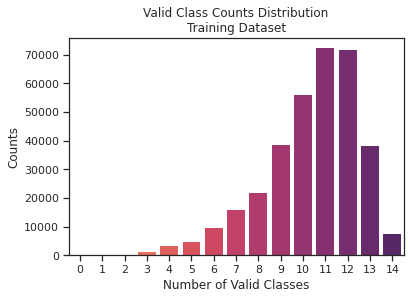

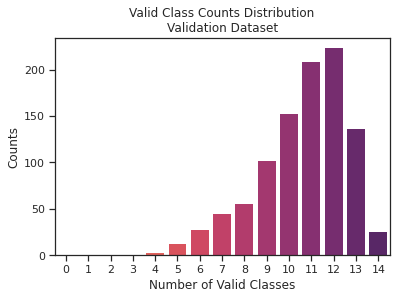

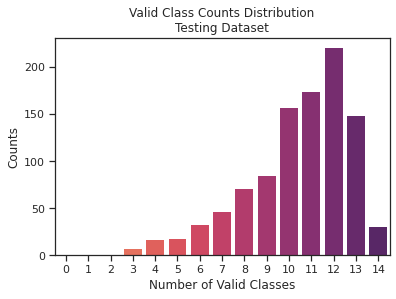

In [14]:
def get_valid_counts(dataset, column_name):
    n_valid, frequency   = np.unique(torch.sum(dataset.x_data[:, 68:102].bool(), dim=1).numpy(), return_counts=True)
    
    data = pd.DataFrame({
        "n_valid_classes": n_valid,
        column_name: frequency
    })
    data = data.set_index('n_valid_classes')
    data = data.reindex(np.arange(0, 14 + 1, dtype=int), fill_value=0)
    
    return data


def display_valid_class_distribution(df, count_column, title):
    # https://seaborn.pydata.org/generated/seaborn.barplot.html#seaborn.barplot
    # http://alanpryorjr.com/visualizations/seaborn/countplot/countplot/
    sns.set(style="ticks", font_scale=1)
    ax = sns.barplot(data=df,
                     x="n_valid_classes", 
                     y=count_column,
                     palette="flare",
                     saturation=10,
                     edgecolor=(0,0,0),
                     linewidth=0,)

    plt.title(title)
    plt.xlabel('Number of Valid Classes')
    plt.ylabel('Counts')
    
    plt.xticks(range(0, 15))

    plt.show()

    
inversion_count_df = pd.concat([
    get_valid_counts(train_dataset      , "training_count"),
    get_valid_counts(validation_dataset , "validation_count"),
    get_valid_counts(test_dataset       , "testing_count")], 
    axis=1).reset_index()

display(inversion_count_df)

display_valid_class_distribution(inversion_count_df, "training_count", 'Valid Class Counts Distribution\nTraining Dataset')
display_valid_class_distribution(inversion_count_df, "validation_count", 'Valid Class Counts Distribution\nValidation Dataset')
display_valid_class_distribution(inversion_count_df, "testing_count", 'Valid Class Counts Distribution\nTesting Dataset')

## Dataset Class Distribution

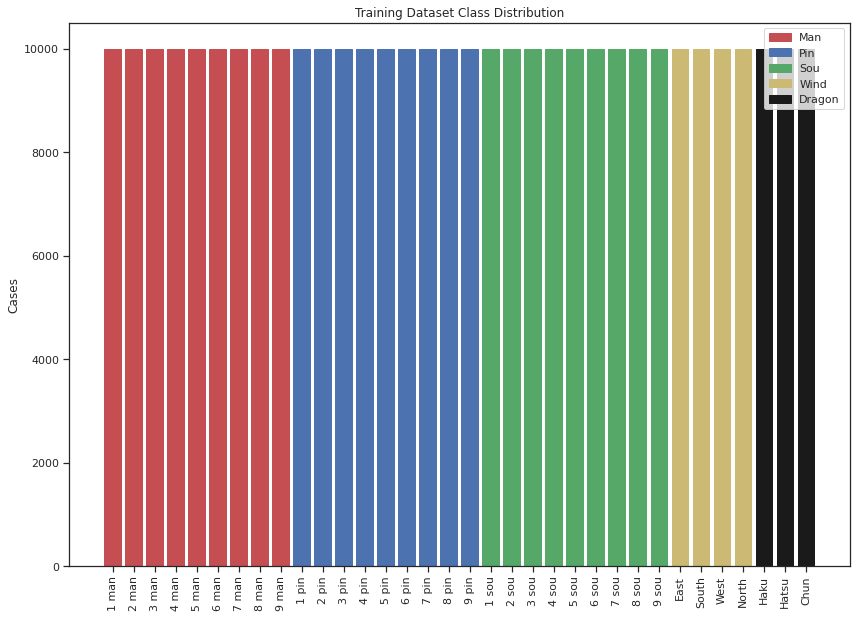

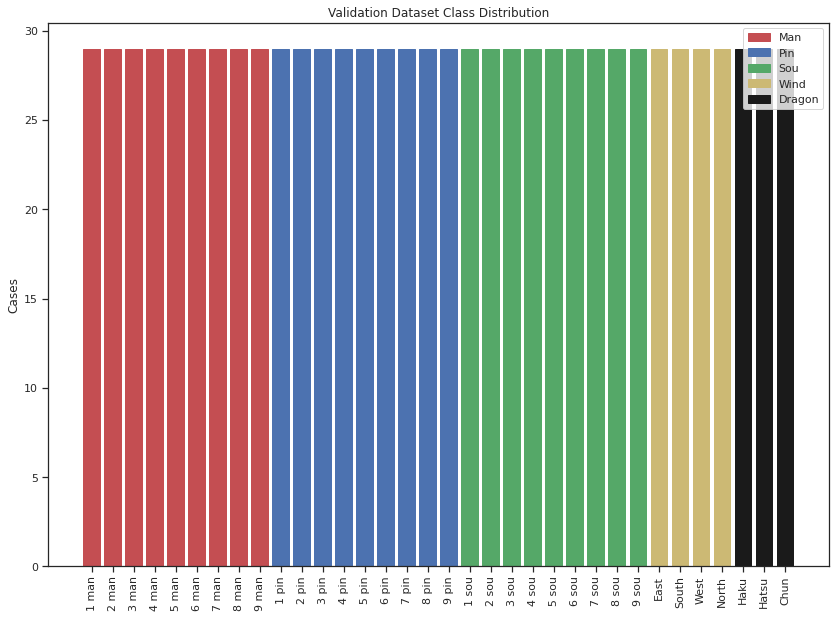

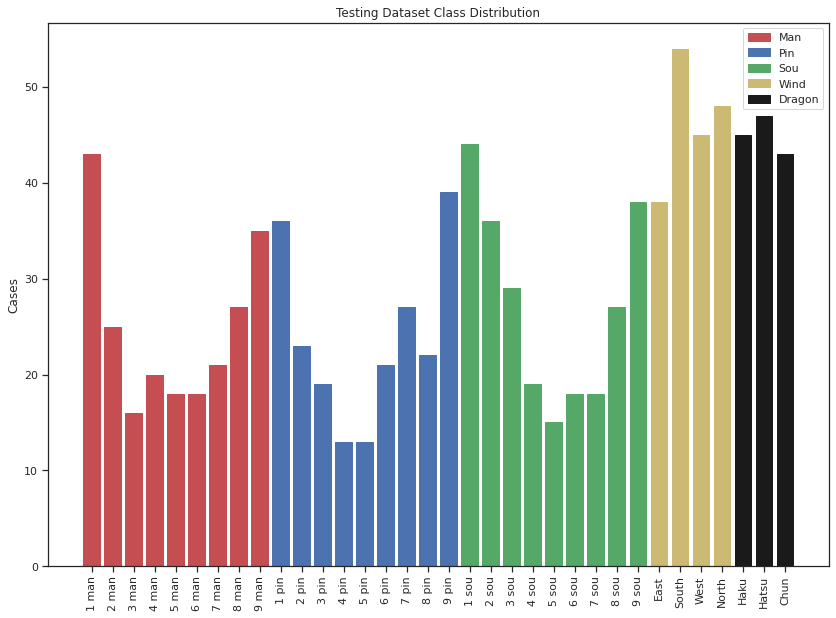

In [15]:
def generate_dataset_class_distribution(Y, title: str, horizontal=False):
    
    keys, counts = np.unique(Y, return_counts=True)
    fig = plt.figure(figsize=(14, 10))

    bar_list = None
    if not horizontal:
        bar_list = plt.bar(keys, counts)
        plt.xticks(range(34), ticks_tiles_oneline, rotation=90)
        plt.ylabel("Cases")
    else:
        bar_list = plt.barh(keys, counts)
        plt.yticks(range(34), ticks_tiles_oneline, rotation=0)
        plt.xlabel("Cases")

    for i in range(0, 9):
        bar_list[i].set_color('r')

    for i in range(9, 18):
        bar_list[i].set_color('b')

    for i in range(18, 27):
        bar_list[i].set_color('g')

    for i in range(27, 31):
        bar_list[i].set_color('y')

    for i in range(31, 34):
        bar_list[i].set_color('k')

    ax = plt.gca()
    legend_man = mpatches.Patch(color='r', label='Man')
    legend_pin = mpatches.Patch(color='b', label='Pin')
    legend_sou = mpatches.Patch(color='g', label='Sou')
    legend_wind = mpatches.Patch(color='y', label='Wind')
    legend_dragons = mpatches.Patch(color='k', label='Dragon')

    plt.title(title)
    plt.legend(handles=[legend_man, legend_pin, legend_sou, legend_wind, legend_dragons])

    plt.show()

generate_dataset_class_distribution(train_dataset.y_data, "Training Dataset Class Distribution", horizontal=False)
generate_dataset_class_distribution(validation_dataset.y_data, "Validation Dataset Class Distribution", horizontal=False)
generate_dataset_class_distribution(test_dataset.y_data, "Testing Dataset Class Distribution", horizontal=False)

# Model Creation

## Basic Network

In [17]:
class Net(torch.nn.Module):
    """ Simple Feed-Forward Net """

    def __init__(self):
        super(Net, self).__init__()
        
        self.name = "BasicDenseNetwork_testing"
        
        self.fc1 = torch.nn.Linear(11 * 34, 1028)
        self.fc2 = torch.nn.Linear(1028, 512)
        self.fc3 = torch.nn.Linear(512, 256)
        self.fc4 = torch.nn.Linear(256, 128)
        self.fc5 = torch.nn.Linear(128, 34)
        
        self.relu_1 = torch.nn.LeakyReLU()
        self.relu_2 = torch.nn.LeakyReLU()
        self.relu_3 = torch.nn.LeakyReLU()
        self.relu_4 = torch.nn.LeakyReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu_1(x)
        
        x = self.fc2(x)
        x = self.relu_2(x)
        
        x = self.fc3(x)
        x = self.relu_3(x)
        
        x = self.fc4(x)
        x = self.relu_4(x)
        
        x = self.fc5(x)

        return x

    
model = Net().to(DEVICE)
criterion = torch.nn.CrossEntropyLoss().to(DEVICE)  # Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

loaded_epoch = 0

model

Net(
  (fc1): Linear(in_features=374, out_features=1028, bias=True)
  (fc2): Linear(in_features=1028, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=34, bias=True)
  (relu_1): LeakyReLU(negative_slope=0.01)
  (relu_2): LeakyReLU(negative_slope=0.01)
  (relu_3): LeakyReLU(negative_slope=0.01)
  (relu_4): LeakyReLU(negative_slope=0.01)
)

In [ ]:
LOAD_FOLDER = None  # Change this to None do NOT want to load anything, otherwise a string to designated model-folder

# TO LOAD OR NOT LOAD
if LOAD_FOLDER:
    CHECKPOINT_PATH = Path('model_checkpoints') / LOAD_FOLDER
    DESCRIPTION_PATH = CHECKPOINT_PATH / 'description.json'
    SUMMARY_PATH = CHECKPOINT_PATH / 'summary.csv'
    INVERSION_STATS_PATH = CHECKPOINT_PATH / 'inversions.csv'
    INVERSION_COUNTS_PATH = CHECKPOINT_PATH / 'inversions_counts.csv'
    HEATMAP_PATH = CHECKPOINT_PATH / 'heatmap.csv'

    last_epoch_file = sorted([c for c in CHECKPOINT_PATH.iterdir() if c.suffix == '.pt'])[-1]
    loaded_checkpoint = torch.load(last_epoch_file)
    print('Loaded Epoch', loaded_checkpoint['epoch'])

    model.load_state_dict(loaded_checkpoint['model_state'])
    optimizer.load_state_dict(loaded_checkpoint['optimizer_state'])
    loaded_epoch = loaded_checkpoint['epoch']

else:
    # Create Model Checkpoint Folder
    timestamp_string = time.strftime('%Y-%m-%d_%H-%M', time.localtime(time.time()))
    CHECKPOINT_PATH = Path('model_checkpoints') / f"{timestamp_string}_{model.name}"
    CHECKPOINT_PATH.mkdir()

    DESCRIPTION_PATH = CHECKPOINT_PATH / 'description.json'
    SUMMARY_PATH = CHECKPOINT_PATH / 'summary.csv'
    INVERSION_STATS_PATH = CHECKPOINT_PATH / 'inversions.csv'
    INVERSION_COUNTS_PATH = CHECKPOINT_PATH / 'inversions_counts.csv'
    HEATMAP_PATH = CHECKPOINT_PATH / 'heatmap.csv'

    model_desc_json = {
        'model_name': model.name,
        'model_description': repr(model),
        'dataset_config': repr(selected_config)
    }

    with open(DESCRIPTION_PATH, 'w') as outfile:
        json.dump(model_desc_json, outfile)

    with open(SUMMARY_PATH, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", 
                         "train_loss", 
                         "train_acc", 
                         "train_average_valid_weight_sum", 
                         "train_average_weight_per_valid_class", 
                         "train_average_weight_per_invalid_class", 
                         "val_loss", 
                         "val_acc", 
                         "val_average_valid_weight_sum", 
                         "val_average_weight_per_valid_class", 
                         "val_average_weight_per_invalid_class",
                         "time_elapsed"])
    
    with open(INVERSION_STATS_PATH, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["mode",
                         "epoch",
                         "n_valid",
                         "min", 
                         "max", 
                         "mean", 
                         "median",])
        
    inversion_count_df.to_csv(INVERSION_COUNTS_PATH, index=False)
    
    with open(HEATMAP_PATH, 'w', newline='') as file:
        writer = csv.writer(file)
        heatmap_fieldnames = ["mode", "epoch", "n_valid"] + [f'h_{i}' for i in range(34)]
        writer.writerow(heatmap_fieldnames)

# TRAINING & VALIDATION

In [ ]:
def seconds_to_hhmmss(s):
    seconds = s
    minutes = seconds // 60
    hours = minutes // 60
    return "%02d:%02d:%02d" % (hours, minutes % 60, seconds % 60)

In [41]:
def get_discard_weight_sum_metrics(hands, logits):
    """ 
    Calculates different weight sum metrics.
    Note: TensorShape of both params must be equal!

    Args:
        hands (Tensor): POV hands as tensor. Expected shape: [b, 34] where b is batch size
        logits (Tensor): logits as tensor. Expected shape: [b, 34] where b is batch size

    Returns:
        tuple(Float, Float): 
            0. First value is the average weight sum of valid discards.
            1. Second value is the average weight sum of valid discards divided by number of valid discard classes.
    """

    class_distributions = F.softmax(logits, dim=1)  # Convert logits into distribution that sums to 1
    masked = hands.bool() * class_distributions  # Mask tensorwise, where invalid classes => 0.
    num_valid_classes = torch.sum(hands.bool(), dim=1)
    sum_valid_weight_sum = torch.sum(masked, dim=1)  # Sum() each row
    
    # Batch Averages
    avg_batch_weight_sum = torch.mean(sum_valid_weight_sum).item()
    avg_batch_weight_sum_per_class = torch.mean(sum_valid_weight_sum / num_valid_classes).item()
    avg_batch_weight_sum_per_class_invalid = torch.mean((1 - sum_valid_weight_sum) / (34 - num_valid_classes)).item()

    return avg_batch_weight_sum, avg_batch_weight_sum_per_class, avg_batch_weight_sum_per_class_invalid

In [ ]:
def generate_sorted_binary_valid_class_tensors(hands, logits):
    return torch.gather(hands.bool(), dim=1, index=torch.argsort(logits, dim=1, descending=True))

In [ ]:
def generate_inversion_rows(mode: str, epoch: int, n_valids, binary_valids) -> list:
    
    assert mode == 'training' or mode == 'validation', f"ILLEGAL MODE: {mode}"
    
    # Count Inversions Formula
    all_inversion_counts = torch.sum(
        torch.cumsum(binary_valids.bitwise_not(), dim=1) * binary_valids, 
        dim=1
    )
    
    inversion_dict_list = []
    for n_valid in range(1, 15):
        mask = n_valids == n_valid
        if True in mask:  # False if mask does not find matching tensors
            arr = all_inversion_counts[mask].cpu().numpy()  # Masked inversion counts tensor      
            inversion_dict_list.append({
                 "mode": 0 if mode == 'training' else 1,
                 "epoch": epoch,
                 "n_valid": n_valid,
                 "min": np.amin(arr), 
                 "max": np.amax(arr), 
                 "mean": np.mean(arr), 
                 "median": np.median(arr),
            })
        else:
            inversion_dict_list.append({
                 "mode": 0 if mode == 'training' else 1,
                 "epoch": epoch,
                 "n_valid": n_valid,
                 "min": np.NAN, 
                 "max": np.NAN, 
                 "mean": np.NAN, 
                 "median": np.NAN,
            })

    return inversion_dict_list

In [ ]:
def generate_heatmap_rows(mode: str, epoch: int, n_valids, binary_valids) -> torch.Tensor:
    
    assert mode == 'training' or mode == 'validation', f"ILLEGAL MODE: {mode}"
    
    heat_tensors = torch.full((14, 34), fill_value=np.NAN).to(DEVICE)
    for n_valid in range(1, 15):
        mask = n_valids == n_valid
        if True in mask:  # False if mask does not find matching tensors
            masked_tensors = binary_valids[mask, :]
            heat_tensors[n_valid-1] = torch.sum(masked_tensors, dim=0) / masked_tensors.shape[0]  # Get average frequency of valid bit for each position
    
    mode_column = torch.zeros((14, 1), dtype=torch.uint8).to(DEVICE) if mode == 'training' else torch.ones((14, 1), dtype=torch.uint8).to(DEVICE)
    epoch_column = torch.full((14, 1), fill_value=epoch).to(DEVICE)
    n_valid_column = torch.arange(start=1, end=15, dtype=torch.uint8).reshape(14, 1).to(DEVICE)
    
    return torch.cat((mode_column, epoch_column, n_valid_column, heat_tensors), dim=1)

In [ ]:
if loaded_epoch != 0:
    loaded_epoch += 1  # If epoch was loaded

# Progress Bars
mq = trange(EPOCHS, desc='EPOCH', unit='epoch', initial=loaded_epoch)
tq = trange(len(train_loader), desc=f'TRAINING', unit='batch')
vq = trange(len(validation_loader), desc=f'VALIDATION', unit='batch')


for epoch in range(loaded_epoch, EPOCHS):
    
    torch.manual_seed(epoch)
    start_timer = timer()  # Start timer

    
    ##############################################
    # TRAINING
    ##############################################
    sum_epoch_loss = 0.0
    sum_epoch_acc = 0.0
    sum_valid_discard_weight_sum = 0.0
    sum_valid_discard_weight_sum_per_tile = 0.0
    sum_invalid_discard_weight_sum_per_tile = 0.0

#     inversion_csv_rows = []    # Inversion helper list (Used by both )
    binary_valid_tensors = []  # For Inversion & Heatmap calculation
    
    model.train()
    for batch_idx, batch in enumerate(train_loader):
        X = batch['X'].to(DEVICE)
        y = batch['y'].to(DEVICE)

        optimizer.zero_grad()

        outputs = model(X)  # Outputs float values for each class (do softmax on `outputs` to get distribution)
        
        # Loss Calculation
        loss = criterion(outputs, y)  # avg loss in batch -> No need for softmax if criterion = Cross Entropy Loss
        sum_epoch_loss += loss.item()

        # Accuracy Calculation
        predictions = torch.argmax(outputs, dim=1)
        num_correct_predictions = torch.sum(torch.eq(predictions, y)).item()
        batch_acc = num_correct_predictions / y.shape[0]  # y.shape[0] = batch_size
        sum_epoch_acc += batch_acc
        
        # Calculate Valid/Invalid Discards weights
        avg_vwsum, avg_vwsum_per_class, avg_iwsum_per_class = get_discard_weight_sum_metrics(hands=X[:, 68:102], logits=outputs)
        sum_valid_discard_weight_sum += avg_vwsum  # Mean() each row into final `valid weight average`
        sum_valid_discard_weight_sum_per_tile += avg_vwsum_per_class
        sum_invalid_discard_weight_sum_per_tile += avg_iwsum_per_class
        
        # Calculate Number of Inversions
        binary_valid_tensors.append(generate_sorted_binary_valid_class_tensors(hands=X[:, 68:102], logits=outputs))

        # Batch Clean-up
        loss.backward()  # compute gradients
        optimizer.step()  # update weights
        
        tq.update(1)
    
    tq.refresh()
    time.sleep(0.1)
    
    # Training Summary Calculations
    avg_acc_train = sum_epoch_acc / len(train_loader)  # average accuracy
    avg_loss_train = sum_epoch_loss / len(train_loader)  # average loss
    avg_valid_discard_weight_sum_train = sum_valid_discard_weight_sum / len(train_loader)  # average valid weight
    sum_valid_discard_weight_sum_per_tile_train = sum_valid_discard_weight_sum_per_tile / len(train_loader)
    sum_invalid_discard_weight_sum_per_tile_train = sum_invalid_discard_weight_sum_per_tile / len(train_loader)
    
    ### INVERSION & HEATMAP Calculation
    binary_valid_tensors = torch.cat(binary_valid_tensors)  # Nested 2D Tensors => Single 2D Tensor
    n_valid_classes = torch.sum(binary_valid_tensors, dim=1)
    inversion_rows_train = generate_inversion_rows('training', epoch, n_valid_classes, binary_valid_tensors)
    heatmap_rows_train = generate_heatmap_rows('training', epoch, n_valid_classes, binary_valid_tensors)
        
    ##############################################
    # VALIDATION
    ##############################################
    sum_epoch_loss = 0.0
    sum_epoch_acc = 0.0
    sum_valid_discard_weight_sum = 0.0
    sum_valid_discard_weight_sum_per_tile = 0.0
    sum_invalid_discard_weight_sum_per_tile = 0.0
    
    binary_valid_tensors = []  # For Inversion & Heatmap calculation

    model.eval()
    for batch_idx, batch in enumerate(validation_loader):
        X = batch['X'].to(DEVICE)
        y = batch['y'].to(DEVICE)

        # optimizer.zero_grad()  # TODO: Needed?

        with torch.no_grad():  # Disables tracking of gradient
            outputs = model(X)
            
        # Loss Calculation
        loss = criterion(outputs, y)  # avg loss in batch
        sum_epoch_loss += loss.item()

        # Accuracy Calculation
        predictions = torch.argmax(outputs, dim=1)
        num_correct_predictions = torch.sum(torch.eq(predictions, y)).item()
        batch_acc = num_correct_predictions / y.shape[0]  # y.shape[0] = batch_size
        sum_epoch_acc += batch_acc
        
        # Calculate Valid/Invalid Discards weights
        avg_vwsum, avg_vwsum_per_class, avg_iwsum_per_class = get_discard_weight_sum_metrics(hands=X[:, 68:102], logits=outputs)
        sum_valid_discard_weight_sum += avg_vwsum  # Mean() each row into final `valid weight average`
        sum_valid_discard_weight_sum_per_tile += avg_vwsum_per_class
        sum_invalid_discard_weight_sum_per_tile += avg_iwsum_per_class
        
        # Calculate Number of Inversions
        binary_valid_tensors.append(generate_sorted_binary_valid_class_tensors(hands=X[:, 68:102], logits=outputs))
        
        vq.update(1)
    
    vq.refresh()
    time.sleep(0.1)
    
    # Training Summary Calculations
    avg_acc_val = sum_epoch_acc / len(validation_loader)  # average accuracy
    avg_loss_val = sum_epoch_loss / len(validation_loader)  # average loss
    avg_valid_discard_weight_sum_val = sum_valid_discard_weight_sum / len(validation_loader)  # average valid weight
    sum_valid_discard_weight_sum_per_tile_val = sum_valid_discard_weight_sum_per_tile / len(validation_loader)
    sum_invalid_discard_weight_sum_per_tile_val = sum_invalid_discard_weight_sum_per_tile / len(validation_loader)
    
    ### INVERSION & HEATMAP Calculation
    binary_valid_tensors = torch.cat(binary_valid_tensors)  # Nested 2D Tensors => Single 2D Tensor
    n_valid_classes = torch.sum(binary_valid_tensors, dim=1)
    inversion_rows_val = generate_inversion_rows('validation', epoch, n_valid_classes, binary_valid_tensors)
    heatmap_rows_val = generate_heatmap_rows('validation', epoch, n_valid_classes, binary_valid_tensors)
    
    ##############################################
    # EPOCH CLEAN-UP
    ##############################################
    elapsed_time = timer() - start_timer  # End Timer
    
    # Print Epoch Summary
    print('EPOCH {:>2}  |  TRAIN: loss={:.3f}, acc={:5.3f}, vwsum={:5.3f} -> valid/invalid={:5.3f}/{:5.3f} |  VALIDATION: loss={:.3f}, acc={:5.3f}, vwsum={:5.3f} -> valid/invalid={:5.3f}/{:5.3f}  | TIME ELAPSED: {}'
          .format(epoch,
                  avg_loss_train, 
                  avg_acc_train,
                  avg_valid_discard_weight_sum_train,
                  sum_valid_discard_weight_sum_per_tile_train,
                  sum_invalid_discard_weight_sum_per_tile_train,
                  avg_loss_val, 
                  avg_acc_val,
                  avg_valid_discard_weight_sum_val,
                  sum_valid_discard_weight_sum_per_tile_val,
                  sum_invalid_discard_weight_sum_per_tile_val,
                  seconds_to_hhmmss(elapsed_time),
                 ))
    
    # Save Epoch Summary to csv
    with open(SUMMARY_PATH, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            epoch, 
            avg_loss_train,
            avg_acc_train,
            avg_valid_discard_weight_sum_train,
            sum_valid_discard_weight_sum_per_tile_train,
            sum_invalid_discard_weight_sum_per_tile_train,
            avg_loss_val,
            avg_acc_val,
            avg_valid_discard_weight_sum_val,
            sum_valid_discard_weight_sum_per_tile_val,
            sum_invalid_discard_weight_sum_per_tile_val,
            seconds_to_hhmmss(elapsed_time)
        ])
        
    with open(INVERSION_STATS_PATH, 'a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=["mode","epoch","n_valid","min", "max", "mean", "median",])
        writer.writerows(inversion_rows_train + inversion_rows_val)
    
    # Heatmap to .csv
    heatmap_combined_np = torch.cat((heatmap_rows_train, heatmap_rows_val), dim=0).cpu().numpy()
    heatmap_df = pd.DataFrame(heatmap_combined_np)
    heatmap_df.to_csv(HEATMAP_PATH, mode='a', header=False, index=False, na_rep='NaN')
        
    # Checkpoint Creation
    training_checkpoint = {
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'epoch': epoch,
    }

    destination = CHECKPOINT_PATH / (f'epoch-{epoch:03}.pt')
    torch.save(training_checkpoint, destination)
    
    # Progress Bar Clean-up
    mq.update(1)
    tq.reset()
    vq.reset()

# Model TESTING

### Load Model for Testing

In [125]:
LOAD_MODEL_FOLDER = "balanced_test_2021-04-18"
LOAD_EPOCH_NUMBER = None  # If None, select epoch with lowest val_loss

CHECKPOINT_PATH = Path('model_checkpoints') / LOAD_MODEL_FOLDER
DESCRIPTION_PATH = CHECKPOINT_PATH / 'description.json'
SUMMARY_PATH = CHECKPOINT_PATH / 'summary.csv'
INVERSION_STATS_PATH = CHECKPOINT_PATH / 'inversions.csv'
INVERSION_COUNTS_PATH = CHECKPOINT_PATH / 'inversions_counts.csv'
HEATMAP_PATH = CHECKPOINT_PATH / 'heatmap.csv'

loaded_checkpoint = None
if not LOAD_EPOCH_NUMBER:
    summary_df = pd.read_csv(SUMMARY_PATH).dropna()
    lowest_val_loss_id = summary_df['val_loss'].idxmin()
    loaded_checkpoint = torch.load(CHECKPOINT_PATH / f"epoch-{lowest_val_loss_id:03}.pt")
else:
    loaded_checkpoint = torch.load(CHECKPOINT_PATH / f"epoch-{LOAD_EPOCH_NUMBER:03}.pt")

model.load_state_dict(loaded_checkpoint['model_state'])
optimizer.load_state_dict(loaded_checkpoint['optimizer_state'])
loaded_epoch = loaded_checkpoint['epoch']

for k, v in json.load(DESCRIPTION_PATH.open()).items():
    print(f"{k}: \n{v}\n")

    print('Loaded Epoch', loaded_checkpoint['epoch'])

model_name: 
BasicDenseNetwork_testing

Loaded Epoch 6
model_description: 
Net(
  (fc1): Linear(in_features=374, out_features=1028, bias=True)
  (fc2): Linear(in_features=1028, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=34, bias=True)
  (relu_1): LeakyReLU(negative_slope=0.01)
  (relu_2): LeakyReLU(negative_slope=0.01)
  (relu_3): LeakyReLU(negative_slope=0.01)
  (relu_4): LeakyReLU(negative_slope=0.01)
)

Loaded Epoch 6
dataset_config: 
train_size          34000000
validation_size      1700000
test_size            1700000
batch                     32
phases                    -1
years_training          1100
years_validation          10
years_testing              1
balanced_data            110
Name: default_balanced, dtype: int64

Loaded Epoch 6


## Testing

In [19]:
print('\nTESTING')

torch.manual_seed(0)

targets = []

pov_hands = []  # 2d list

# sorted_output_logits = []
output_logits = []


# Confidence metric: We track how far away the correct guess was from prediction.
# prediction_indices = []  # List of indices of correct target in list of predicted output values. Optimally should only contain 0s. List of indices between [0, 33] # RENAMED TO CORRECT_INDICES

# sorted_prediction_indices = []

model.eval()
for batch_idx, batch in enumerate(tqdm(test_loader, total=len(test_loader), desc=f'Testing', unit='batch')):

    X = batch['X'].to(DEVICE)
    y = batch['y'].to(DEVICE)
    
    optimizer.zero_grad()
    with torch.no_grad():
        output = model(X)
    
    output = output[0]  # output is shape[1, 34] due to batching process, this line undoes it to shape[34]
    
    output_logits.append(output)
    pov_hands.append(X[0][68:102])
    targets.append(y.item())


sorted_logits, sorted_logits_indices = torch.sort(torch.vstack(output_logits), descending=True)  # sorted_logits_indices = sorted_prediction_indices
correct_indices = [c.index(targets[i]) for i, c in enumerate(sorted_logits_indices.tolist())]
predictions = [p[0].item() for p in sorted_logits_indices]  # Creation of predictions list (deferred for optimization)


TESTING


Testing:   0%|          | 0/1000 [00:00<?, ?batch/s]

## Top K Accuracy

In [20]:
prediction_correctness = Counter()  # 0 = perfect predictions, 33 = worst prediction case

assert len(targets) == len(sorted_logits_indices)

for index_of_prediction in correct_indices:
    prediction_correctness[index_of_prediction] += 1
    
# Accuracy of Top Predictions
for i in range(34):
    top_sum = 0
    for j in range(i + 1):
        top_sum += prediction_correctness[j]
    
    print(f"Top {i+1:>2} : {top_sum / len(targets):6.3f}")

Top  1 :  0.328
Top  2 :  0.501
Top  3 :  0.622
Top  4 :  0.699
Top  5 :  0.775
Top  6 :  0.831
Top  7 :  0.879
Top  8 :  0.903
Top  9 :  0.919
Top 10 :  0.935
Top 11 :  0.947
Top 12 :  0.956
Top 13 :  0.966
Top 14 :  0.973
Top 15 :  0.981
Top 16 :  0.989
Top 17 :  0.992
Top 18 :  0.993
Top 19 :  0.994
Top 20 :  0.994
Top 21 :  0.996
Top 22 :  0.996
Top 23 :  0.999
Top 24 :  0.999
Top 25 :  1.000
Top 26 :  1.000
Top 27 :  1.000
Top 28 :  1.000
Top 29 :  1.000
Top 30 :  1.000
Top 31 :  1.000
Top 32 :  1.000
Top 33 :  1.000
Top 34 :  1.000


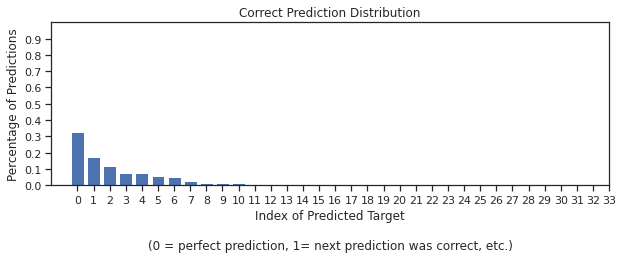

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))

plt.bar(prediction_correctness.keys(), [v / len(targets) for v in prediction_correctness.values()])
plt.ylim(0, 1)
plt.yticks(np.arange(0.0, 1.0, 0.1))
plt.xticks(range(34))

plt.title('Correct Prediction Distribution')
plt.xlabel('Index of Predicted Target\n\n(0 = perfect prediction, 1= next prediction was correct, etc.)')
plt.ylabel('Percentage of Predictions')

plt.show()

## Calculate Invalid Discards Metrics

In [39]:
invalid_discards_dict = {}
hand_tensor = torch.vstack(pov_hands).to(DEVICE)
for top_index in range(0, 34):
    top_N_mask = sorted_logits_indices[:, top_index].reshape(-1, 1)  # Column with current selected indices rowise
    found_values = hand_tensor.gather(dim=1, index=top_N_mask)
    invalid_discards_dict[top_index] = torch.sum(found_values == 0)
    
# Accuracy of Top Predictions
print("Top K Accumulated Invalid Discards")
for i in range(34):
    top_sum = 0
    for j in range(i + 1):
        top_sum += invalid_discards_dict[j]
    
    print(f"Top {i+1:>2}: {top_sum:>8}  (+{invalid_discards_dict[i]:>5})")

print("\nTop 1 Summary:")
print("- Number of Invalid Discard Prediction: {}".format(invalid_discards_dict[0]))
print("- Invalid Discard Percentage: {}".format(invalid_discards_dict[0] / len(targets)))

Top K Accumulated Invalid Discards
Top  1:        8  (+    8)
Top  2:       53  (+   45)
Top  3:      152  (+   99)
Top  4:      308  (+  156)
Top  5:      561  (+  253)
Top  6:      890  (+  329)
Top  7:     1267  (+  377)
Top  8:     1773  (+  506)
Top  9:     2334  (+  561)
Top 10:     2930  (+  596)
Top 11:     3527  (+  597)
Top 12:     4147  (+  620)
Top 13:     4773  (+  626)
Top 14:     5403  (+  630)
Top 15:     6120  (+  717)
Top 16:     6845  (+  725)
Top 17:     7640  (+  795)
Top 18:     8468  (+  828)
Top 19:     9320  (+  852)
Top 20:    10164  (+  844)
Top 21:    11047  (+  883)
Top 22:    11926  (+  879)
Top 23:    12831  (+  905)
Top 24:    13771  (+  940)
Top 25:    14713  (+  942)
Top 26:    15685  (+  972)
Top 27:    16653  (+  968)
Top 28:    17622  (+  969)
Top 29:    18600  (+  978)
Top 30:    19586  (+  986)
Top 31:    20576  (+  990)
Top 32:    21563  (+  987)
Top 33:    22549  (+  986)
Top 34:    23542  (+  993)

Top 1 Summary:
- Number of Invalid Discard Pre

### Valid / Invalid Discard Weight Sum

##### Valid Tiles vs Valid Classes
An important note is that we should be mindful about the subtle difference between valid **tiles** vs valid **classes**.
A given hand can be in this format: 
```python
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
```
Note that there's 2 tiles of class `21`. 
In this example:
- number of **valid tiles**   = 11
- number of **valid classes** = 10

**Note:** The number of **valid tiles** >= The number of **valid classes**

In [42]:
hand_tensor = torch.vstack(pov_hands).to(DEVICE)
logits_tensor = torch.vstack(output_logits).to(DEVICE)
avg_ws, avg_ws_valid, avg_ws_invalid = get_discard_weight_sum_metrics(hand_tensor, logits_tensor)

valid_tiles = torch.sum(hand_tensor, dim=1)
avg_valid_tiles = torch.mean(valid_tiles.float()).item()

valid_classes = torch.sum(hand_tensor.bool(), dim=1)
avg_valid_classes = torch.mean(valid_classes.float()).item()

print(f'Average Valid Weight Sum:             {avg_ws:>6.3f}')
print(f'Average Weight Sum per Valid Class:   {avg_ws_valid:>6.3f}')
print(f'Average Weight Sum per Invalid Class: {avg_ws_invalid:>6.3f}')
print(f'Average Number of Valid Tiles:        {avg_valid_tiles:>6.3f}')
print(f'Average Number of Valid Classes:      {avg_valid_classes:>6.3f}')

Average Valid Weight Sum:              0.844
Average Weight Sum per Valid Class:    0.086
Average Weight Sum per Invalid Class:  0.007
Average Number of Valid Tiles:        12.859
Average Number of Valid Classes:      10.458


## More elaborated accuracy metric
- Check if any of top 3 predictions are correct.
- Check if any of the predictions prioritized above target are invalid discards.
    - Note that this only applies if target is not top 1 predicted class.

## Weight Confidence Distribution
Aka. "Average Prediction Weight Density".

Top K Weight Confidence Distribution
Top  1:    0.338  (+0.338)
Top  2:    0.509  (+0.171)
Top  3:    0.622  (+0.113)
Top  4:    0.705  (+0.083)
Top  5:    0.768  (+0.063)
Top  6:    0.816  (+0.048)
Top  7:    0.854  (+0.038)
Top  8:    0.884  (+0.031)
Top  9:    0.909  (+0.025)
Top 10:    0.929  (+0.020)
Top 11:    0.946  (+0.017)
Top 12:    0.959  (+0.013)
Top 13:    0.970  (+0.010)
Top 14:    0.977  (+0.008)
Top 15:    0.983  (+0.006)
Top 16:    0.987  (+0.004)
Top 17:    0.990  (+0.003)
Top 18:    0.993  (+0.002)
Top 19:    0.994  (+0.002)
Top 20:    0.995  (+0.001)
Top 21:    0.996  (+0.001)
Top 22:    0.997  (+0.001)
Top 23:    0.998  (+0.001)
Top 24:    0.998  (+0.000)
Top 25:    0.999  (+0.000)
Top 26:    0.999  (+0.000)
Top 27:    0.999  (+0.000)
Top 28:    0.999  (+0.000)
Top 29:    1.000  (+0.000)
Top 30:    1.000  (+0.000)
Top 31:    1.000  (+0.000)
Top 32:    1.000  (+0.000)
Top 33:    1.000  (+0.000)
Top 34:    1.000  (+0.000)

On average, the top 1 prediction is allocate

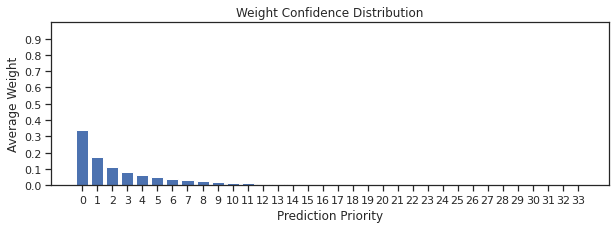

In [62]:
sorted_output_distribution = F.softmax(sorted_logits, dim=1)
numpy_distribution = sorted_output_distribution.cpu().detach().numpy()
avg_distribution = np.mean(numpy_distribution, axis=0)

print("Top K Weight Confidence Distribution")
for i in range(34):
    top_sum = 0
    for j in range(i + 1):
        top_sum += avg_distribution[j]
    
    print(f"Top {i+1:>2}: {top_sum:>8.3f}  (+{avg_distribution[i]:>5.3f})")
    
print("\nOn average, the top 1 prediction is allocated {:>5.2f}% of total weight.".format(avg_distribution[0] * 100))
print("On average, the top 3 predictions are allocated {:>5.2f}% of total weight.".format(sum(avg_distribution[[0,1,2]]) * 100))

plt.figure(figsize=(10, 3))
plt.bar(range(34), avg_distribution)

plt.ylim(0, 1)
plt.yticks(np.arange(0.0, 1.0, 0.1))
plt.xticks(range(34))

plt.title('Weight Confidence Distribution')
plt.xlabel('Prediction Priority')
plt.ylabel('Average Weight')

plt.show()

## F1 Score and Recall

In [58]:
# TODO: Add Target names for better looking table: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
print(sklearn.metrics.classification_report(targets, predictions, digits=3, zero_division=1, target_names=ticks_tiles_oneline))  

              precision    recall  f1-score   support

       1 man      0.500     0.186     0.271        43
       2 man      0.314     0.440     0.367        25
       3 man      0.000     0.000     0.000        16
       4 man      0.091     0.100     0.095        20
       5 man      0.429     0.500     0.462        18
       6 man      0.500     0.444     0.471        18
       7 man      0.333     0.429     0.375        21
       8 man      0.667     0.074     0.133        27
       9 man      0.529     0.514     0.522        35
       1 pin      0.342     0.361     0.351        36
       2 pin      0.200     0.348     0.254        23
       3 pin      0.435     0.526     0.476        19
       4 pin      0.057     0.462     0.102        13
       5 pin      0.429     0.231     0.300        13
       6 pin      0.250     0.238     0.244        21
       7 pin      0.182     0.148     0.163        27
       8 pin      0.000     0.000     0.000        22
       9 pin      0.407    

# Various Graphs and Metrics

## Class Distribution

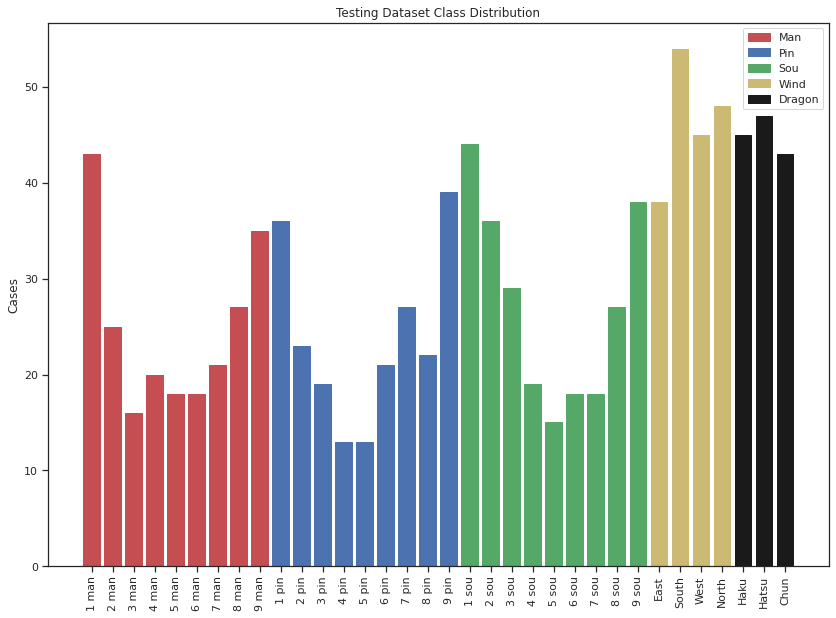

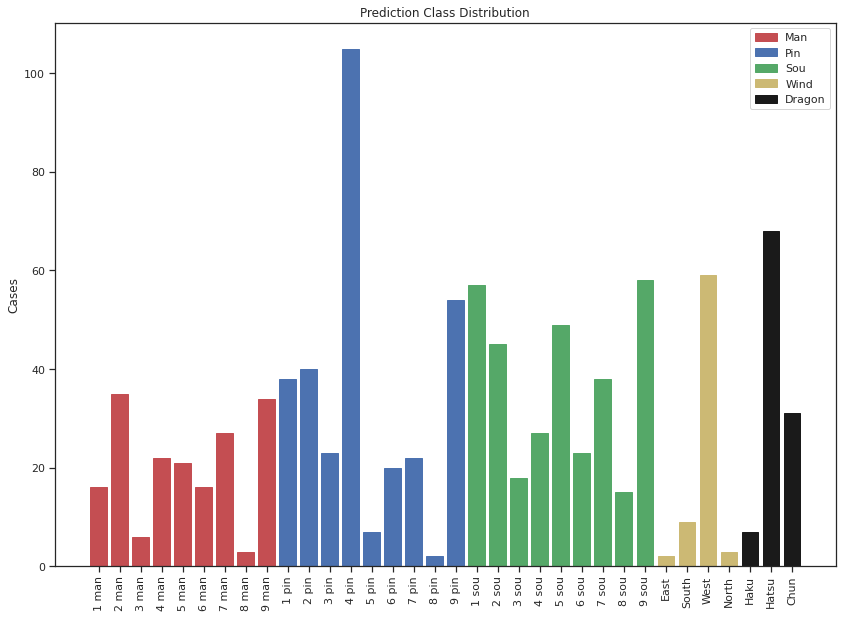

In [63]:
generate_dataset_class_distribution(test_dataset.y_data, "Testing Dataset Class Distribution", horizontal=False)
generate_dataset_class_distribution(predictions, "Prediction Class Distribution", horizontal=False)

### Concatenated Distribution

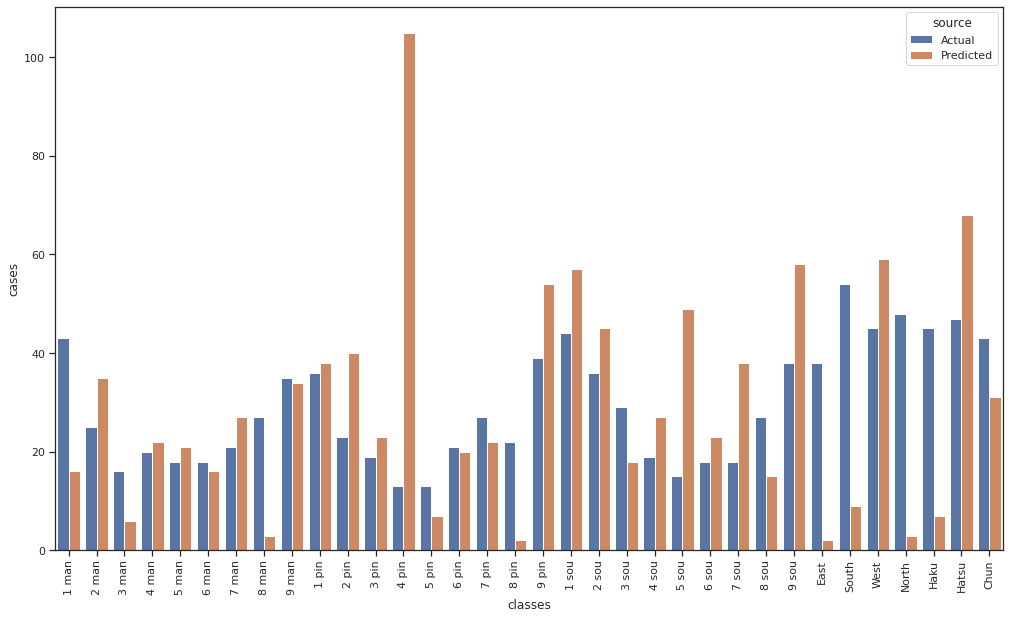

In [64]:
keys_0, counts_0 = np.unique(test_dataset.y_data, return_counts=True)
keys_1, counts_1 = np.unique(predictions, return_counts=True)

fig = plt.figure(figsize=(17, 10))

df1 = pd.DataFrame({'classes':keys_0, 'cases':counts_0})
df2 = pd.DataFrame({'classes':keys_1, 'cases':counts_1})

df1['source'] = "Actual"
df2['source'] = "Predicted"

res=pd.concat([df1, df2])

sns.barplot(x='classes',y='cases', data=res, hue='source')
plt.xticks(range(34), ticks_tiles_oneline, rotation=90)

plt.show()

## Confusion Matrix

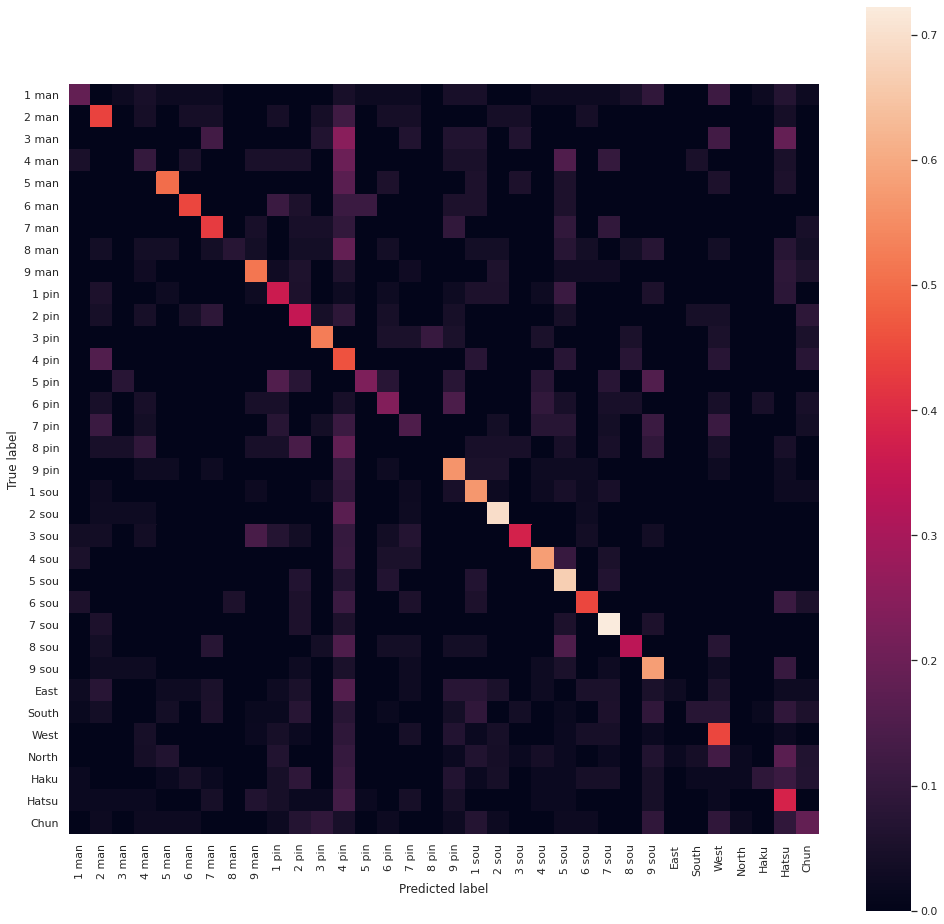

In [65]:
confusion_nparray = sklearn.metrics.confusion_matrix(targets, predictions, normalize='true')
df_cm = pd.DataFrame(confusion_nparray)
plt.figure(figsize=(14, 13))
sns.set(font_scale=1) # for label size
sns.heatmap(df_cm, annot=False, annot_kws={"size": 10}, square=True, xticklabels=ticks_tiles_oneline, yticklabels=ticks_tiles_oneline) # font size

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

## Accuracy and Loss Graphs

In [66]:
summary = pd.read_csv(SUMMARY_PATH, index_col='epoch').dropna()
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 0 to 6
Data columns (total 11 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   train_loss                              7 non-null      float64
 1   train_acc                               7 non-null      float64
 2   train_average_valid_weight_sum          7 non-null      float64
 3   train_average_weight_per_valid_class    7 non-null      float64
 4   train_average_weight_per_invalid_class  7 non-null      float64
 5   val_loss                                7 non-null      float64
 6   val_acc                                 7 non-null      float64
 7   val_average_valid_weight_sum            7 non-null      float64
 8   val_average_weight_per_valid_class      7 non-null      float64
 9   val_average_weight_per_invalid_class    7 non-null      float64
 10  time_elapsed                            7 non-null      object 
dt

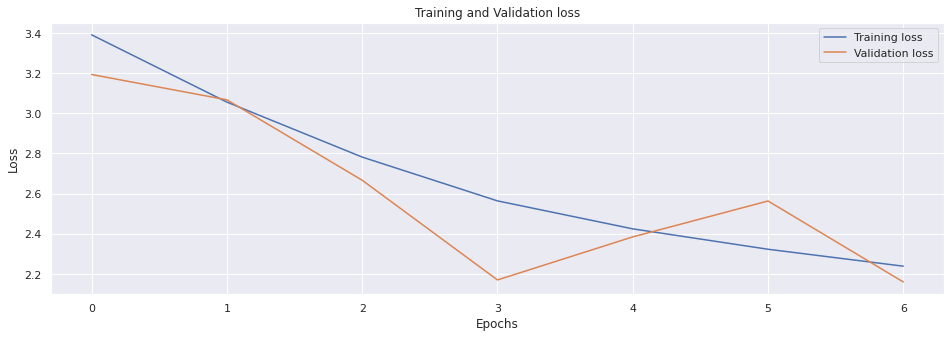

In [67]:
loss_train = summary['train_loss']
loss_val = summary['val_loss']
epochs = summary.index

figure = plt.figure(figsize=(16, 5))

plt.xticks(list(summary.index))

plt.plot(epochs, loss_train, label='Training loss')
plt.plot(epochs, loss_val, label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

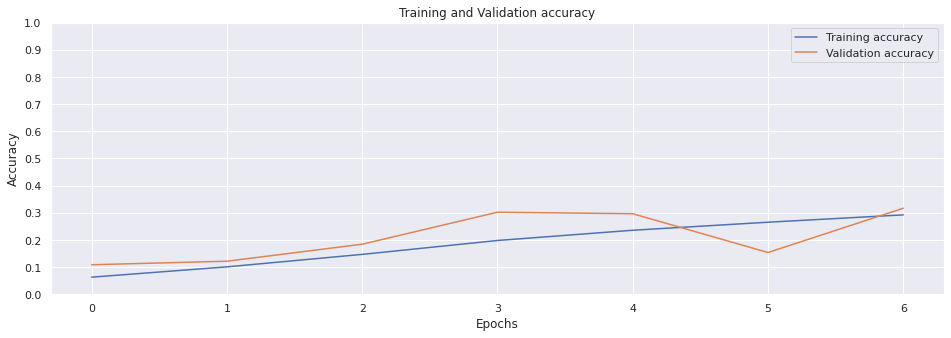

In [90]:
loss_train = summary['train_acc']
loss_val = summary['val_acc']
epochs = list(summary.index)

figure = plt.figure(figsize=(16, 5))

plt.xticks(list(summary.index))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1)

plt.plot(epochs, loss_train, label='Training accuracy')
plt.plot(epochs, loss_val, label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Average Total Weight Sum

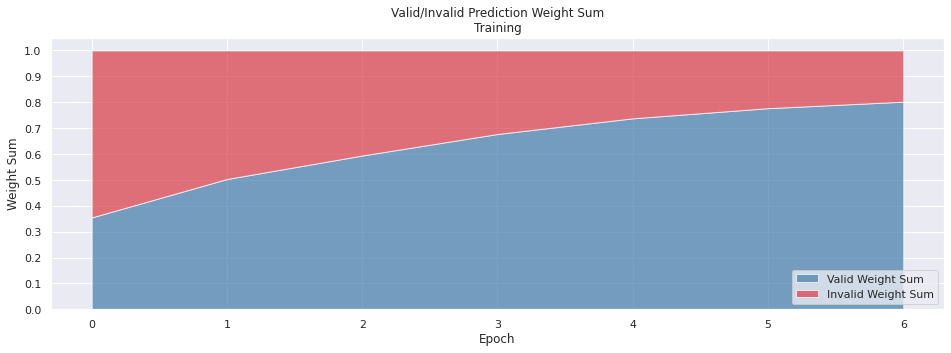

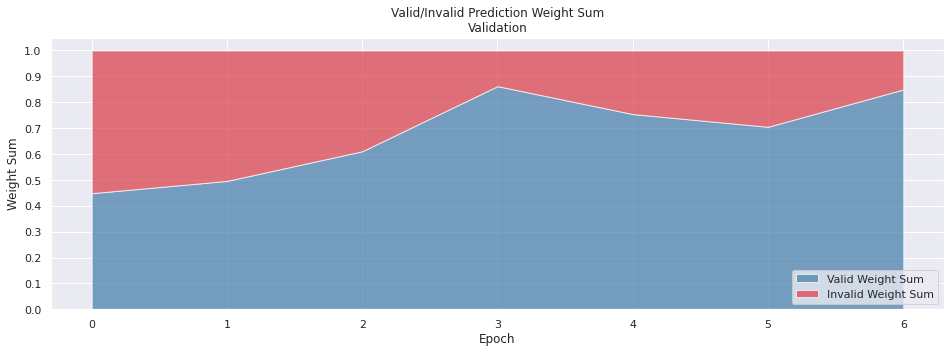

In [121]:
def graph_weigh_sum_epochwise(weigh_sum_column, title):
    x = range(0, len(weigh_sum_column))
    y = [weigh_sum_column, (1 - weigh_sum_column)]

    figure = plt.figure(figsize=(16, 5))

    plt.stackplot(x, y, 
                  labels=['Valid Weight Sum', 'Invalid Weight Sum'], 
                  alpha=0.7,
                  colors=diverging_palette_light)
    
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xticks(np.arange(0, len(weigh_sum_column), 1))

    plt.legend(loc='lower right')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Weight Sum')

    plt.show()

graph_weigh_sum_epochwise(summary['train_average_valid_weight_sum'], "Valid/Invalid Prediction Weight Sum\nTraining")
graph_weigh_sum_epochwise(summary['val_average_valid_weight_sum'], "Valid/Invalid Prediction Weight Sum\nValidation")

# Heatmap

In [293]:
heatmap_df = pd.read_csv(HEATMAP_PATH)
heatmap_df = heatmap_df.astype({'mode': 'int32', 'epoch': 'int32', 'n_valid': 'int32'})
heatmap_df

,mode,epoch,n_valid,h_0,h_1,h_2,h_3,h_4,h_5,h_6,...,h_24,h_25,h_26,h_27,h_28,h_29,h_30,h_31,h_32,h_33
0,0,0,1,0.085106,0.106383,0.021277,0.042553,0.042553,0.000000,0.042553,...,0.021277,0.021277,0.000000,0.042553,0.021277,0.021277,0.000000,0.000000,0.000000,0.000000
1,0,0,2,0.139774,0.115557,0.100948,0.093051,0.089760,0.078968,0.075809,...,0.043169,0.037641,0.040669,0.044485,0.041063,0.042248,0.035404,0.035272,0.033561,0.029087
2,0,0,3,0.264495,0.201728,0.175064,0.151184,0.139293,0.129854,0.121682,...,0.052664,0.050230,0.047284,0.052924,0.049969,0.047140,0.044446,0.040468,0.036507,0.031397
3,0,0,4,0.322087,0.263882,0.231546,0.210707,0.194856,0.181018,0.170964,...,0.065638,0.061894,0.058335,0.057863,0.054307,0.051194,0.045724,0.042678,0.037695,0.032687
4,0,0,5,0.375513,0.315085,0.279350,0.254408,0.236217,0.222445,0.211125,...,0.085014,0.081061,0.077508,0.077902,0.073892,0.069165,0.063045,0.058922,0.051831,0.044316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,1,6,10,0.996067,0.979794,0.943287,0.887663,0.812684,0.716749,0.610673,...,0.031140,0.024302,0.019505,0.015540,0.012230,0.010977,0.009781,0.008834,0.008414,0.006955
192,1,6,11,0.995491,0.977647,0.938669,0.881214,0.808615,0.725318,0.639419,...,0.041641,0.033365,0.027140,0.021842,0.018079,0.015623,0.013918,0.012277,0.012277,0.010175
193,1,6,12,0.995161,0.972818,0.928075,0.865605,0.794296,0.724069,0.658559,...,0.055932,0.044542,0.036566,0.029573,0.025339,0.021771,0.019471,0.018385,0.018446,0.014936
194,1,6,13,0.994514,0.968282,0.916005,0.847872,0.777416,0.715668,0.672125,...,0.073453,0.058864,0.047892,0.041158,0.034965,0.030300,0.028113,0.027110,0.027328,0.020605


In [308]:
heatmap_df[(heatmap_df['mode'] == 0) & (heatmap_df['epoch'] == 6)]

,mode,epoch,n_valid,h_0,h_1,h_2,h_3,h_4,h_5,h_6,...,h_24,h_25,h_26,h_27,h_28,h_29,h_30,h_31,h_32,h_33
168,0,6,1,0.574468,0.191489,0.127660,0.000000,0.021277,0.021277,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
169,0,6,2,0.837720,0.620558,0.215715,0.105159,0.064359,0.045933,0.030929,...,0.000526,0.000395,0.000395,0.000132,0.000263,0.000263,0.000263,0.000000,0.000132,0.000790
170,0,6,3,0.854869,0.766408,0.577083,0.307280,0.167206,0.102894,0.067985,...,0.000251,0.000269,0.000216,0.000180,0.000144,0.000171,0.000126,0.000108,0.000198,0.000305
171,0,6,4,0.882782,0.817337,0.693941,0.512131,0.326277,0.212780,0.147722,...,0.001154,0.000948,0.000748,0.000729,0.000475,0.000393,0.000368,0.000304,0.000342,0.000466
172,0,6,5,0.888428,0.840089,0.748590,0.618276,0.472063,0.335716,0.241206,...,0.004149,0.003408,0.002914,0.002199,0.001802,0.001406,0.001066,0.000832,0.000737,0.000676
173,0,6,6,0.897621,0.863566,0.788394,0.670988,0.546178,0.431617,0.334151,...,0.008610,0.006754,0.005350,0.004260,0.003287,0.002562,0.001950,0.001504,0.001174,0.001015
174,0,6,7,0.911586,0.881326,0.818282,0.726362,0.619911,0.516536,0.424647,...,0.012502,0.009901,0.007883,0.006152,0.004925,0.003871,0.002861,0.002153,0.001686,0.001326
175,0,6,8,0.921675,0.901075,0.856692,0.789176,0.705503,0.613117,0.523376,...,0.016104,0.012788,0.010304,0.008248,0.006467,0.005066,0.003804,0.002954,0.002197,0.001738
176,0,6,9,0.931425,0.914123,0.875879,0.818102,0.747404,0.670190,0.592534,...,0.020845,0.016852,0.013438,0.010830,0.008551,0.006686,0.005182,0.003883,0.002829,0.002210
177,0,6,10,0.937239,0.917364,0.879481,0.827668,0.766265,0.700376,0.635938,...,0.028949,0.023488,0.018692,0.015184,0.012189,0.009576,0.007448,0.005621,0.004085,0.003062


In [364]:
sns.__version__

'0.11.1'

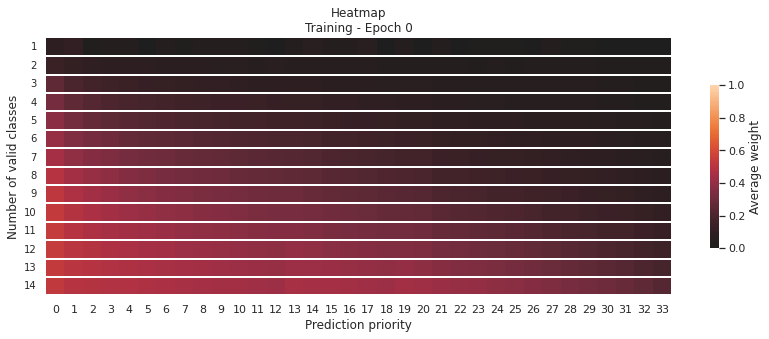

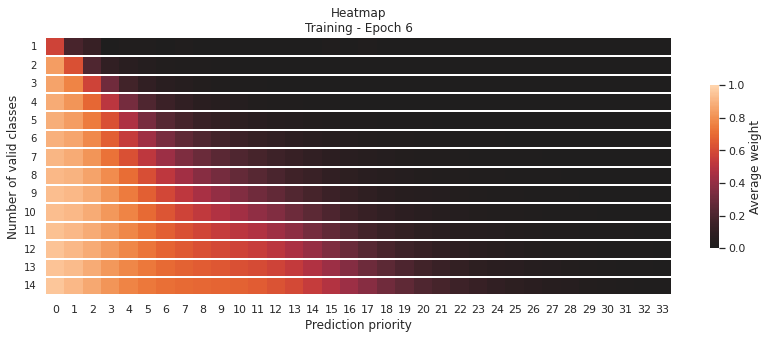

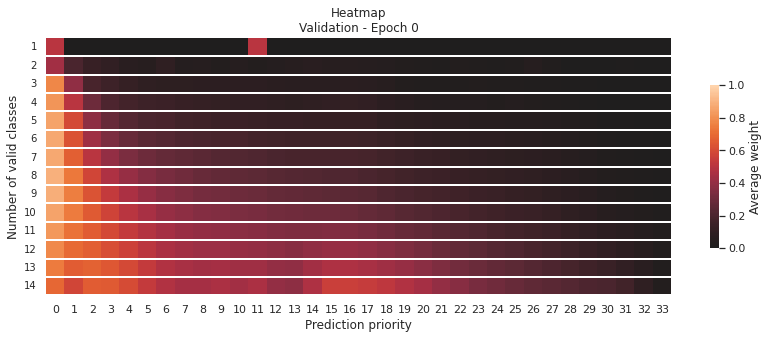

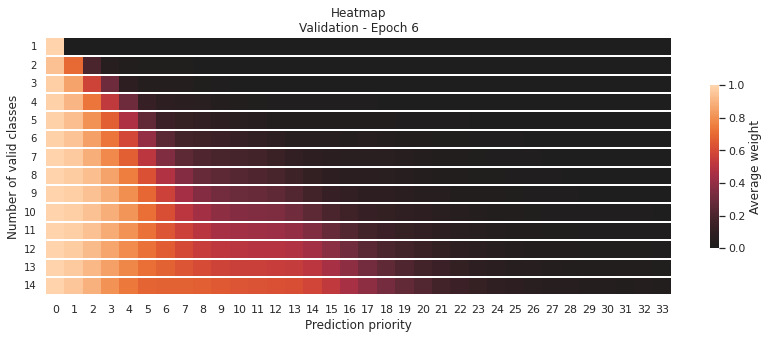

In [391]:
def graph_heatmap(df, mode: int, epoch: int):
    
    filtered_df = df[(df['mode'] == mode) & (df['epoch'] == epoch)]
    
    assert len(filtered_df) == 14, f"NOT ENOUGH ROWS FOR HEATMAP! EXPECTED 14, got {len(filtered_df)}"
    
    plt.figure(figsize=(14, 5))
    ax = sns.heatmap(filtered_df.drop(columns=['mode', 'epoch', 'n_valid']), 
#                      annot=True, 
        #             fmt="g", 
                     cmap="icefire",
                     center=0,
        #             linewidths=.8,
                     vmin=0, vmax=1,
                     square=True,
                     xticklabels=range(0, 34),
                     yticklabels=range(1, 15),
                     cbar=True,
                     cbar_kws=dict(shrink=0.6, label='Average weight', ticks=np.arange(0.0, 1.2, 0.2))
                )

    ax.hlines(range(1, 15), -0.2, 34, linewidth=2, color="white")
  
    plt.title(f"Heatmap\n{'Training' if mode == 0 else 'Validation'} - Epoch {epoch}")
    
    plt.xlabel('Prediction priority')
    plt.ylabel('Number of valid classes')
#     plt.xticks(rotation=0, fontsize=10, va="center")
    plt.yticks(rotation=0, fontsize=10, va="center")



    plt.show()
    
graph_heatmap(heatmap_df, 0, 0)
graph_heatmap(heatmap_df, 0, 6)

graph_heatmap(heatmap_df, 1, 0)
graph_heatmap(heatmap_df, 1, 6)

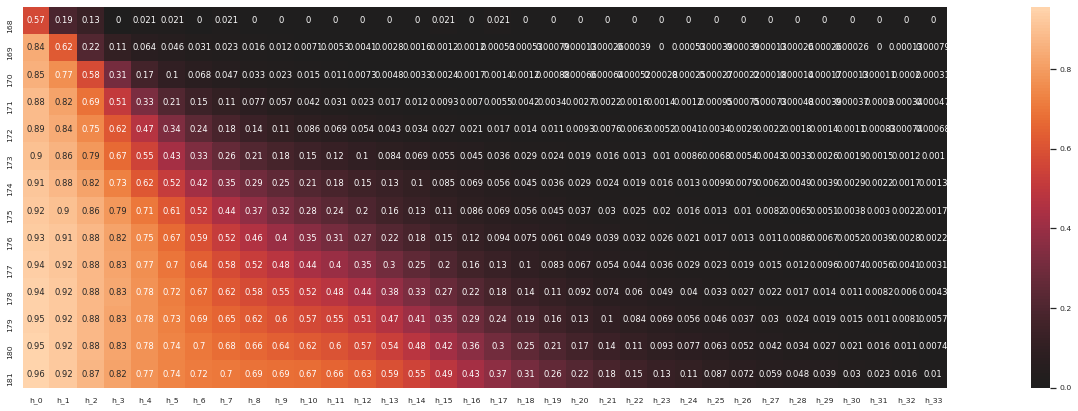

In [217]:
plt.figure(figsize=(30, 7))

sns.heatmap(heatmap_df.drop(columns=['mode', 'epoch', 'n_valid']).iloc[168:182], 
            annot=True, 
#             fmt="g", 
            cmap="icefire",
            center=0,
            square=True,
#             linewidths=.8,
#             rasterized=False
           )
sns.set(font_scale=0.7) # for label size
plt.grid(True, axis='y', color='r', linestyle='-', linewidth=2)

plt.show()